# CSCI 3345, Machine Learning, Spring 2024


In [ ]:
%pip install torch torchvision
%pip install chess
%pip install tqdm
%pip install svgwrite

In [ ]:
import numpy as np
import chess
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random
import svgwrite
import chess.svg
from tqdm.notebook import trange
from IPython.display import SVG, display, clear_output


In [ ]:
def generate_moves(piece):
    board = chess.Board(None)  # Create an empty chess board
    moves = []

    for square in chess.SQUARES:
        board.set_piece_at(square, piece)
        moves.append([str(move) for move in board.legal_moves])
        board.remove_piece_at(square)

    return moves

def get_move_matrix():
  moves_count = 0
  move_list = []
  move_q = {}
  move_k = {}

  #generate queen moves
  queen_moves = generate_moves(chess.Piece(chess.QUEEN, chess.WHITE))
  print("Queen moves:")
  for square, moves in zip(chess.SQUARE_NAMES, queen_moves):
      #print(f"{square}: {moves}")
      move_q[square] = moves
      for i in moves:
        moves_count+=1

  # Generate moves for a knight
  knight_moves = generate_moves(chess.Piece(chess.KNIGHT, chess.WHITE))
  print("\nKnight moves:")
  for square, moves in zip(chess.SQUARE_NAMES, knight_moves):
      #print(f"{square}: {moves}")
      move_k[square] = moves
      for i in moves:
        moves_count+=1

  for key1 in move_q:
    for key2 in move_k:
      if key1 == key2:
        for move in move_q[key1]:
          move_list.append(move)
        for i in move_k[key2]:
          move_list.append(i)
  #return np.array(move_list)

  #We must add an extra 44 moves for the promotion (22 for black and 22 for white)
  move_list.append("a7a8q")
  move_list.append("a7b8q")
  move_list.append("b7b8q")
  move_list.append("b7a8q")
  move_list.append("b7c8q")
  move_list.append("c7c8q")
  move_list.append("c7b8q")
  move_list.append("c7d8q")
  move_list.append("d7d8q")
  move_list.append("d7c8q")
  move_list.append("d7e8q")
  move_list.append("e7e8q")
  move_list.append("e7d8q")
  move_list.append("e7f8q")
  move_list.append("f7f8q")
  move_list.append("f7e8q")
  move_list.append("f7g8q")
  move_list.append("g7g8q")
  move_list.append("g7f8q")
  move_list.append("g7h8q")
  move_list.append("h7h8q")
  move_list.append("h7g8q")

  move_list.append("a2a1q")
  move_list.append("a2b1q")
  move_list.append("b2b1q")
  move_list.append("b2a1q")
  move_list.append("b2c1q")
  move_list.append("c2c1q")
  move_list.append("c2b1q")
  move_list.append("c2d1q")
  move_list.append("d2d1q")
  move_list.append("d2c1q")
  move_list.append("d2e1q")
  move_list.append("e2e1q")
  move_list.append("e2d1q")
  move_list.append("e2f1q")
  move_list.append("f2f1q")
  move_list.append("f2e1q")
  move_list.append("f2g1q")
  move_list.append("g2g1q")
  move_list.append("g2f1q")
  move_list.append("g2h1q")
  move_list.append("h2h1q")
  move_list.append("h2g1q")


  print(len(move_list))
  move_list = np.array(move_list)
  np.save('moves.npy', move_list)

get_move_matrix()

Queen moves:

Knight moves:
1836


In [ ]:
moves = np.load('moves.npy')
class ChessInterface:
  def __init__(self):
    self.row_count = 8
    self.column_count = 8
    self.action_size = len(moves)
    self.actions = moves


  def get_initial_state(self):
    return chess.Board().fen()

  def get_next_state(self, state, action):
    board = chess.Board()
    board.set_fen(state)
    move = chess.Move.from_uci(action)
    board.push(move)
    state = board.fen()
    return state

  def get_valid_moves(self, state):
    board = chess.Board()
    board.set_fen(state)
    uci_moves = [move.uci() for move in board.legal_moves]
    return uci_moves

  def get_valid_moves_matrix(self, state):
    moves = self.actions
    valid_moves = self.get_valid_moves(state)
    valid_move_matrix = np.zeros(self.action_size)
    for i, move in enumerate(moves):
      for j in valid_moves:
        if move == j:
          valid_move_matrix[i] = 1
    return valid_move_matrix.astype(np.float32)

  def check_win(self, state, action):
    if action == None:
      return False
    board = chess.Board()
    board.set_fen(state)
    if board.is_checkmate():
      return True
    return False


  def get_value_and_terminated(self, state, action):
    board = chess.Board()
    board.set_fen(state)
    if self.check_win(state, action):
      return 1, True
    if board.outcome() != None:
      return 0, True
    return 0, False

  def get_opponent(self, player):
    return -player

  def get_opponent_value(self, value):
    return -value

    return_matrices = []

    if isinstance(state, np.str_) == False:
        for i in range(len(state)):
          board = chess.Board(state[i])
          pieces = ['p', 'n', 'b', 'r', 'q', 'k', 'P', 'N', 'B', 'R', 'Q', 'K']
          matrices = []

          for piece in pieces:
              matrix = np.zeros((8, 8))
              for i in range(64):
                  if str(board.piece_at(i)) == piece:
                      matrix[i // 8, i % 8] = 1
              matrices.append(matrix)

          # Add a matrix for all free squares
          free_squares = np.zeros((8, 8))
          for i in range(64):
              if board.piece_at(i) is None:
                  free_squares[i // 8, i % 8] = 1
          matrices.append(free_squares)
          matrices = np.array(matrices)
          return_matrices.append(matrices)

    else:
          board = chess.Board(state)
          pieces = ['p', 'n', 'b', 'r', 'q', 'k', 'P', 'N', 'B', 'R', 'Q', 'K']
          matrices = []

          for piece in pieces:
              matrix = np.zeros((8, 8))
              for i in range(64):
                  if str(board.piece_at(i)) == piece:
                      matrix[i // 8, i % 8] = 1
              return_matrices.append(matrix)

          # Add a matrix for all free squares
          free_squares = np.zeros((8, 8))
          for i in range(64):
              if board.piece_at(i) is None:
                  free_squares[i // 8, i % 8] = 1
          return_matrices.append(free_squares)

    return_matrices = np.array(return_matrices)

    return return_matrices.astype(np.float32)
    # first matrix corresponds to the first indice of the piece_types array above, the second to the second indice and so on...



$\textrm{output_size} = \textrm{input_size}-\textrm{kernel_size}+2\cdot\textrm{padding}+1$

In [ ]:
class ResNet(nn.Module):
  def __init__(self, game, num_resBlocks, num_hidden, device):
    super().__init__()

    self.device = device
    self.startBlock = nn.Sequential(
      nn.Conv2d(13, num_hidden, kernel_size = 3, padding = 1),
      nn.BatchNorm2d(num_hidden),
      nn.ReLU()
    )
    self.backBone = nn.ModuleList(
      [ResBlock(num_hidden) for i in range(num_resBlocks)]
    )
    self.policyHead = nn.Sequential(
      nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(32 * game.row_count * game.column_count, game.action_size)
    )
    self.valueHead = nn.Sequential(
      nn.Conv2d(num_hidden, 13, kernel_size=3, padding=1),
      nn.BatchNorm2d(13),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(13 * game.row_count * game.column_count, 1),
      nn.Tanh()
    )
    self.to(device)

  def forward(self, x):
    x = self.startBlock(x)
    for resBlock in self.backBone:
        x = resBlock(x)
    policy = self.policyHead(x)
    value = self.valueHead(x)
    return policy, value

class ResBlock(nn.Module):
  def __init__(self, num_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size = 3, padding = 1)
    self.bn1 = nn.BatchNorm2d(num_hidden)
    self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size = 3, padding = 1)
    self.bn2 = nn.BatchNorm2d(num_hidden)

  def forward(self, x):
    residual = x
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.bn2(self.conv2(x))
    x += residual
    x = F.relu(x)
    return x


In [ ]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count = 0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        self.children = []
        self.visit_count = visit_count
        self.value_sum = 0

    def is_fully_expanded(self):
        return len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
        return best_child

    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

    def expand(self, policy):
        for action, prob in enumerate(policy):
          if prob > 0:
            move = self.game.actions[action]
            child_state = self.state
            child_state = self.game.get_next_state(child_state, move)
            child = Node(self.game, self.args, child_state, self, move, prob)
            self.children.append(child)

    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)


class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad()
    def search(self, state):
        root = Node(self.game, self.args, state, visit_count=1)
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state), device=self.model.device).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] *
        np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size)
        valid_moves = self.game.get_valid_moves_matrix(state)
        policy *= valid_moves
        policy /= np.sum(policy)
        root.expand(policy)
        for search in range(self.args['num_searches']):
            #selection
            node = root
            while node.is_fully_expanded():
                node = node.select()
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)

            if not is_terminal:
                #expansion
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state),
                                 device=self.model.device).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves_matrix(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)
                value = value.item()
                node.expand(policy)
            #backpropagate
            node.backpropagate(value)
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[np.where(self.game.actions == child.action_taken)] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs


In [ ]:
class MCTSParallel:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad()
    def search(self, states, spGames):


        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(states), device=self.model.device)
        )
        policy = torch.softmax(policy, axis=1).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size, size=policy.shape[0])

        for i, spg in enumerate(spGames):
            spg_policy = policy[i]
            valid_moves = self.game.get_valid_moves_matrix(states[i])
            spg_policy *= valid_moves
            spg_policy /= np.sum(spg_policy)

            spg.root = Node(self.game, self.args, states[i], visit_count=1)
            spg.root.expand(spg_policy)

        for search in range(self.args['num_searches']):
            for spg in spGames:
                spg.node = None
                node = spg.root

                while node.is_fully_expanded():
                    node = node.select()

                value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
                value = self.game.get_opponent_value(value)

                if is_terminal:
                    node.backpropagate(value)

                else:
                    spg.node = node

            expandable_spGames = [mappingIdx for mappingIdx in range(len(spGames)) if spGames[mappingIdx].node is not None]

            if len(expandable_spGames) > 0:
                states = np.stack([spGames[mappingIdx].node.state for mappingIdx in expandable_spGames])

                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(states), device=self.model.device)
                )
                policy = torch.softmax(policy, axis=1).cpu().numpy()
                value = value.cpu().numpy()

            for i, mappingIdx in enumerate(expandable_spGames):
                node = spGames[mappingIdx].node
                spg_policy, spg_value = policy[i], value[i]

                valid_moves = self.game.get_valid_moves_matrix(node.state)
                spg_policy *= valid_moves
                spg_policy /= np.sum(spg_policy)

                node.expand(spg_policy)
                node.backpropagate(spg_value)

In [ ]:
class AlphaZero():
  def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, model)

  def SelfPlay(self):
    memory = []
    player = 1
    state = self.game.get_initial_state()

    while True:
        action_probs = self.mcts.search(state)

        memory.append((state, action_probs, player))

        temperature_action_probs = action_probs ** (1 / self.args['temperature'])
        temperature_action_probs = temperature_action_probs / np.sum(temperature_action_probs)
        action = np.random.choice(self.game.action_size, p=temperature_action_probs)
        action = self.game.actions[action]

        state = self.game.get_next_state(state, action)

        value, is_terminal = self.game.get_value_and_terminated(state, action)

        if is_terminal:
            returnMemory = []
            for hist_state, hist_action_probs, hist_player in memory:
                hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                returnMemory.append(
                    (self.game.get_encoded_state(hist_state),
                    hist_action_probs,
                    hist_outcome)
                )
            return returnMemory

        player = self.game.get_opponent(player)




  def train(self, memory):
      random.shuffle(memory)
      for batchIdx in range(0,len(memory), self.args['batch_size']):
          sample = memory[batchIdx:min(len(memory)-1,batchIdx + self.args['batch_size'])]
          state, policy_targets, value_targets = zip(*sample)

          state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)

          state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
          policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
          value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

          out_policy, out_value = self.model(state)

          policy_loss = F.cross_entropy(out_policy, policy_targets)
          value_loss = F.mse_loss(out_value, value_targets)

          loss = policy_loss + value_loss

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()



  def learn(self):
      for iteration in trange(self.args['num_iterations']):
          memory = []

          self.model.eval()
          for selfPlay_iterations in trange(self.args['num_selfPlay_iterations']):
            memory += self.SelfPlay()

          self.model.train()
          for epoch in trange(self.args['num_epochs']):
            self.train(memory)

          torch.save(self.model.state_dict(), f"model_{iteration}.pt")
          torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")

class SPG:
    def __init__(self, game):
        self.state = game.get_initial_state()
        self.memory = []
        self.root = None
        self.node = None


In [ ]:
class AlphaZeroParallel():
  def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTSParallel(game, args, model)

  def SelfPlay(self):
    return_memory = []
    player = 1
    state = self.game.get_initial_state()
    board = chess.Board()
    spGames = [SPG(self.game) for spg in range(self.args['num_parallel_games'])]

    while len(spGames) > 0:
        states = np.stack([spg.state for spg in spGames])

        self.mcts.search(states, spGames)

        for i in range(len(spGames))[::-1]:
                spg = spGames[i]

                action_probs = np.zeros(self.game.action_size)
                for child in spg.root.children:
                    action_probs[np.where(self.game.actions == child.action_taken)] = child.visit_count
                action_probs /= np.sum(action_probs)

                spg.memory.append((spg.root.state, action_probs, player))

                temperature_action_probs = action_probs ** (1 / self.args['temperature'])
                temperature_action_probs = temperature_action_probs / np.sum(temperature_action_probs)
                action = np.random.choice(self.game.action_size, p=temperature_action_probs)
                action = self.game.actions[action]

                spg.state = self.game.get_next_state(spg.state, action)

                value, is_terminal = self.game.get_value_and_terminated(spg.state, action)

                if is_terminal:
                    for hist_state, hist_action_probs, hist_player in spg.memory:
                        hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                        return_memory.append(
                            (self.game.get_encoded_state(hist_state),
                            hist_action_probs,
                            hist_outcome)
                        )
                    del spGames[i]

        player = self.game.get_opponent(player)

    return return_memory




  def train(self, memory):
      random.shuffle(memory)
      for batchIdx in range(0,len(memory), self.args['batch_size']):
          sample = memory[batchIdx:min(len(memory)-1,batchIdx + self.args['batch_size'])]
          state, policy_targets, value_targets = zip(*sample)

          state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)

          state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
          policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
          value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

          out_policy, out_value = self.model(state)

          policy_loss = F.cross_entropy(out_policy, policy_targets)
          value_loss = F.mse_loss(out_value, value_targets)

          loss = policy_loss + value_loss

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()



  def learn(self):
      for iteration in trange(self.args['num_iterations']):
          memory = []

          self.model.eval()
          for selfPlay_iterations in trange(self.args['num_selfPlay_iterations'] // self.args['num_parallel_games']):
            memory += self.SelfPlay()

          self.model.train()
          for epoch in trange(self.args['num_epochs']):
            self.train(memory)

          torch.save(self.model.state_dict(), f"model_{iteration}.pt")
          torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")



Show Policy works and graphs it after some moves

In [ ]:
import matplotlib.pyplot as plt
moves = np.load('moves.npy')
chessGm = ChessInterface()

state = chessGm.get_initial_state()
state = chessGm.get_next_state(state, 'e2e3')
state = chessGm.get_next_state(state, 'e7e6')

print(state)

encoded_state = chessGm.get_encoded_state(state)

print(encoded_state)

tensor_state = torch.tensor(encoded_state).unsqueeze(0)

model = ResNet(chessGm, 4, 64)

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

valid_moves = chessGm.get_valid_moves_matrix(state)
move = chessGm.get_valid_moves(state)

policy = policy * valid_moves
policy /= np.sum(policy)

check = True
for i, prob in enumerate(policy):
  if prob != 0:
    if moves[i] not in move:
      check = False
print(check)
print(np.sum(policy))


print(value, policy)

plt.bar(range(chessGm.action_size), policy)
plt.show()

play the game demo

In [ ]:
chessGm = ChessInterface()
board = chess.Board()

state = chessGm.get_initial_state()

display(board)
while True:
    valid_moves = chessGm.get_valid_moves(state)
    print("valid_moves", valid_moves)
    action = input(f"move:")

    while action not in valid_moves:
      print("invalid move")
      action = input(f"move:")
    state = chessGm.get_next_state(state, action)
    board.set_fen(state)
    display(board)


    value, is_terminal = chessGm.get_value_and_terminated(state, action)

    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break

    player = chessGm.get_opponent(player)

MCTS Demo

In [ ]:
chessGM = ChessInterface()
player = 1
move_list = np.load('moves.npy')
board = chess.Board()

args = {
    'C': 2,
    'num_searches': 1000
}

model = ResNet(chessGM, 4, 64)
model.eval()

mcts = MCTS(chessGM, args, model)

state = chessGM.get_initial_state()


while True:
    print(player)
    print(state)
    display(board)

    if player == 1:
        valid_moves = chessGM.get_valid_moves(state)
        print("valid_moves", valid_moves)
        action = input(f"{player}:")

        if action not in valid_moves:
            print("action not valid")
            continue

    else:
        mcts_probs = mcts.search(state)
        action = move_list[np.argmax(mcts_probs)]

    state = chessGM.get_next_state(state, action)
    board.set_fen(state)

    value, is_terminal = chessGM.get_value_and_terminated(state, action)

    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break

    player = chessGM.get_opponent(player)

In [ ]:
chessGM = ChessInterface()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(chessGM, 4, 16, device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'C': 2,
    'num_searches': 100,
    'num_iterations': 5,
    'num_selfPlay_iterations': 2,
    'num_parallel_games' : 2,
    'num_epochs': 10,
    'batch_size': 128,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.002
}

alphaZero = AlphaZeroParallel(model, optimizer, chessGM, args)
alphaZero.learn()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Driver Programs
def initialize_chess_AI():
    chessGM = ChessInterface()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNet(chessGM, 4, 16, device)
    model.load_state_dict(torch.load("model_4.pt")) # CHANGE to most recent model
    model.eval()
    return chessGM, model

def play_game():
    chessGM, model = initialize_chess_AI()
    board = chess.Board()
    board_size = 300
    display(SVG(chess.svg.board(board=board, size=board_size)))
    state = chessGM.get_initial_state()

    while not board.is_game_over():
        if board.turn == chess.WHITE:
            valid_moves = chessGM.get_valid_moves(state)
            print("Valid moves:", valid_moves)
            action = input("Enter Move: ")

            while action not in valid_moves:
                print("Invalid move. Try again.")
                action = input("Enter Move: ")

            state = chessGM.get_next_state(state, action)
            board.set_fen(state)
            clear_output(wait=True)
            display(SVG(chess.svg.board(board=board, size=board_size)))

        else: # AI's move
            encoded_state = chessGM.get_encoded_state(state)
            state_tensor = torch.tensor(encoded_state, dtype=torch.float32).unsqueeze(0).to(model.device)
            policy, _ = model(state_tensor)
            legal_moves = [move.uci() for move in board.legal_moves]

            legal_policy = [policy[0, chess.Move.from_uci(move).from_square].detach().numpy() if move in legal_moves else float('-inf') for move in chessGM.actions]
            best_move_idx = np.argmax(legal_policy)
            best_move = chessGM.actions[best_move_idx]

            state = chessGM.get_next_state(state, best_move)
            board.set_fen(state)
            clear_output(wait=True)
            display(SVG(chess.svg.board(board=board, size=board_size)))

    print("Game Over")
    if board.is_checkmate():
        print("Checkmate!")
        print("Winner:", "White" if board.turn == chess.BLACK else "Black")
    elif board.is_stalemate():
        print("Stalemate! It's a draw.")
    elif board.is_insufficient_material():
        print("Insufficient material. It's a draw.")
    elif board.is_seventyfive_moves():
        print("Seventy-five moves rule. It's a draw.")
    elif board.is_fivefold_repetition():
        print("Fivefold repetition. It's a draw.")
    else:
        print("Unknown result.")

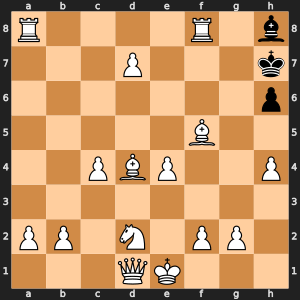

Game Over
Checkmate!
Winner: White


In [ ]:
play_game()